In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
!pip install "opencv-python-headless<4.3"
!pip install opencv-python

import cv2
import xml.etree.ElementTree as ET
import pickle as cPickle
import argparse

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T

import torch.nn as nn
import torch

!pip install git+https://github.com/albumentations-team/albumentations.git
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import sys
# change the path to access the dataset
sys.path.insert(0,"/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/dataset")

In [ ]:
## Dataset with the non-bird images
# class BirdDataset(torch.utils.data.Dataset):
#     """Class to charecterize the bird dataset"""

#     def __init__(self, root_dir, transforms=None, ntransforms=None):
#         """
#         Args:
#             root_dir (string): Directory with all the images
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.root = root_dir
#         self.transforms = transforms
#         self.ntransforms = ntransforms
        
#         # list of all image names - jpg
#         self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "all_images")), key=lambda x: int(os.path.splitext(x)[0])))
#         self.imgs += list(sorted(os.listdir(os.path.join(root_dir, "all_nimages")), key=lambda x: int(os.path.splitext(x)[0].split('n')[1])))
#         # print(self.imgs)
#         # list of all image names - xml
#         self.boxes = list(sorted(os.listdir(os.path.join(root_dir, "all_labels")), key=lambda x: int(os.path.splitext(x)[0])))
    
#     def __len__(self):
#         return len(self.imgs)

#     def __getitem__(self, idx):
#         """Loads and returns a sample from the dataset at the given index idx"""
#         # load images and boxes
#         type_image = self.imgs[idx].split('n')
#         negative_image = False
#         if len(type_image) == 2:
#           img_path = os.path.join(self.root, "all_nimages", self.imgs[idx])
#           negative_image = True
#         else:
#           img_path = os.path.join(self.root, "all_images", self.imgs[idx])
#         # print("Image path", img_path)
#         # img = cv2.imread(img_path, cv2.IMREAD_COLOR) # doesn't work for YOLOv5
#         img = cv2.imread(img_path)[:,:,::-1]
#         # print(cv2.imread(img_path)[:,:,::-1].shape)
#         # print(cv2.imread(img_path).shape)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
#         img /= 255.0
        
#         if not negative_image:
#           box_path = os.path.join(self.root, "all_labels", self.boxes[idx])
#           # get boxes for each bird
#           document = ET.parse(box_path)
#           root = document.getroot()
#           boxes = []
#           for item in root.findall(".//object/bndbox"):
#               xmin = float(item.find('xmin').text)
#               xmax = float(item.find('xmax').text)
#               ymin = float(item.find('ymin').text)
#               ymax = float(item.find('ymax').text)

#               box = [xmin, ymin, xmax, ymax]
#               boxes.append(box)       
#           num_objs = len(boxes)
#           boxes = torch.as_tensor(boxes, dtype=torch.float32)
#           labels = torch.ones((num_objs,), dtype=torch.int64) # only one class : a bird
#         else:
#           boxes = torch.zeros((0, 4), dtype=torch.float32)
#           labels = torch.zeros((1, 1), dtype=torch.int64)

#         # convert everything into a torch.Tensor
#         image_id = torch.tensor([idx+1])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         # target["masks"] = masks
#         target["image_id"] = image_id
#         target["area"] = area
#         # target["iscrowd"] = iscrowd

#         if (self.transforms is not None) & (not negative_image):
#           # img = self.transforms(img)
#           sample = {
#               'image': img,
#               'bboxes': target['boxes'],
#               'labels': labels
#           }
#           sample = self.transforms(**sample)

#           img = sample['image']
#           if len(sample['bboxes']) == 0: # If after cropping, there are no bounding boxes
#               target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
#               target['labels'] = torch.zeros((1, 1), dtype=torch.int64)
#           else:
#             target['boxes'] = torch.tensor(sample['bboxes'])
#             target['labels'] = torch.as_tensor(sample['labels'],dtype=torch.int64)

#         if (self.ntransforms is not None) & (negative_image):
#           sample = self.ntransforms(image=img)
#           img = sample['image']

#         return img, target

## Dataset only with the bird images
class BirdDataset(torch.utils.data.Dataset):
    """Class to charecterize the bird dataset"""

    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root_dir
        self.transforms = transforms
        
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "all_images")), key=lambda x: int(os.path.splitext(x)[0])))  # list of all image names - jpg
        self.boxes = list(sorted(os.listdir(os.path.join(root_dir, "all_labels")), key=lambda x: int(os.path.splitext(x)[0]))) # list of all image names - xml
    
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the given index idx"""
        # load images and boxes
        img_path = os.path.join(self.root, "all_images", self.imgs[idx])
        box_path = os.path.join(self.root, "all_labels", self.boxes[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        
        # get boxes for each bird
        document = ET.parse(box_path)
        root = document.getroot()
        boxes = []
        for item in root.findall(".//object/bndbox"):
            xmin = float(item.find('xmin').text)
            xmax = float(item.find('xmax').text)
            ymin = float(item.find('ymin').text)
            ymax = float(item.find('ymax').text)

            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
        num_objs = len(boxes)

        # convert everything into a torch.Tensor
        image_id = torch.tensor([idx+1])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64) # only one class : a bird
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        # target["iscrowd"] = iscrowd

        if self.transforms is not None:
            # img = self.transforms(img)
            sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)

            img = sample['image']
            if len(sample['bboxes']) == 0: # 
                target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            else:
                target['boxes'] = torch.tensor(sample['bboxes'])

        return img, target

In [ ]:
def get_MobileNetmodel(trained=True, save_path=None):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

  num_classes = 2  # 1 class (bird) + background

  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  if trained:
    if save_path == None: print("No path to the saved model")
    else: model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
  model.to(device)
  return model

def get_MobileNet320model(trained=True, save_path=None):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

  num_classes = 2  # 1 class (bird) + background

  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  if trained:
    if save_path == None: print("No path to the saved model")
    else: model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
  model.to(device)
  return model

def get_ResNet50model(trained=True, save_path=None):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  num_classes = 2  # 1 class (bird) + background

  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  if trained:
      if save_path == None: print("No path to the saved model")
      else: model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
  model.to(device)
  return model

In [ ]:
#########
# UTILS #
#########
def collate_fn(batch):
  """Necessary for DataLoader"""
  return tuple(zip(*batch))

def get_transform(train):
  """Tansform the training and test set. Data Augmentation is made here."""
  transforms = []
  # transforms.append(A.Resize(224, 224, interpolation = cv2.INTER_LANCZOS4))
  if train:
    transforms.append(A.Flip(0.5))
    transforms.append(A.ColorJitter())
    transforms.append(A.PadIfNeeded(576, 576, border_mode=cv2.BORDER_CONSTANT))
    transforms.append(A.RandomCrop(width=576, height=576))
    # transforms.append(A.Resize(224, 224, interpolation=cv2.INTER_LANCZOS4))     
  else:
    transforms.append(A.PadIfNeeded(576, 576, border_mode=cv2.BORDER_CONSTANT))
    # transforms.append(A.CenterCrop(width=576, height=576))
    # transforms.append(A.Resize(224, 224, interpolation=cv2.INTER_LANCZOS4))
  transforms.append(ToTensorV2(p=1.0)) 
  return A.Compose(transforms, bbox_params={'format': 'pascal_voc', 'min_visibility': 0.5, 'label_fields': ['labels']})

def get_negtransform(train):
  """Tansform the training and test set for the neagtive images (no bounding boxes). Data Augmentation is made here."""
  transforms = []
  if train:
    transforms.append(A.Flip(0.5))
    transforms.append(A.ColorJitter())
    transforms.append(A.PadIfNeeded(576, 576, border_mode=cv2.BORDER_CONSTANT))
    transforms.append(A.RandomCrop(width=576, height=576))
    transforms.append(A.Resize(224, 224, interpolation=cv2.INTER_LANCZOS4)) 
  else:
    transforms.append(A.PadIfNeeded(576, 576, border_mode=cv2.BORDER_CONSTANT))
    transforms.append(A.RandomCrop(width=576, height=576))
    transforms.append(A.Resize(224, 224, interpolation=cv2.INTER_LANCZOS4)) 
  transforms.append(ToTensorV2(p=1.0)) 
  return A.Compose(transforms)

class Performance():
    """Class to calculate and store the performance/score of a model"""
    def __init__(self, root_save=None, args=None):
        """
        Args:
            root_save (string): 
            params (callable, optional):
        """
        self.root_save = root_save
        self.args = args
        self.epoch_loss_class = []
        self.epoch_loss_boxreg = []
        self.epoch_loss_obj = []
        self.epoch_loss_rpnboxreg = []
        self.epochs_mean_training = [[], [], [], []]
        self.epochs_mean_validation = [[], [], [], []]
        self.all_means_training = [[], [], [], []]
        self.all_means_validation = [[], [], [], []]

        self.epochtps = []
        self.epochscore = []
        self.epochgtnbr = 0
        # self.all_avgprecision = []

    def reset(self):
      self.epoch_loss_class =  []
      self.epoch_loss_boxreg = []
      self.epoch_loss_obj = []
      self.epoch_loss_rpnboxreg = []
      self.epoch_avgprecision = []

    def reset_epoch(self):
      self.epochs_mean_training = [[], [], [], []]
      self.epochs_mean_validation = [[], [], [], []]

    def add_score(self, values):
      """
      Add the different score of the model for every iteration to the corresponding list of score
      values : dictionnary containing  'loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'
      """
      self.epoch_loss_class.append(values['loss_classifier'].cpu().detach().item())
      self.epoch_loss_boxreg.append(values['loss_box_reg'].cpu().detach().item())
      self.epoch_loss_obj.append(values['loss_objectness'].cpu().detach().item())
      self.epoch_loss_rpnboxreg.append(values['loss_rpn_box_reg'].cpu().detach().item())

    def add_mean(self, training):
      if training:
        self.epochs_mean_training[0].append(sum(self.epoch_loss_class)/len(self.epoch_loss_class))
        self.epochs_mean_training[1].append(sum(self.epoch_loss_boxreg)/len(self.epoch_loss_boxreg))
        self.epochs_mean_training[2].append(sum(self.epoch_loss_obj)/len(self.epoch_loss_obj))
        self.epochs_mean_training[3].append(sum(self.epoch_loss_rpnboxreg)/len(self.epoch_loss_rpnboxreg))
      else:
        self.epochs_mean_validation[0].append(sum(self.epoch_loss_class)/len(self.epoch_loss_class))
        self.epochs_mean_validation[1].append(sum(self.epoch_loss_boxreg)/len(self.epoch_loss_boxreg))
        self.epochs_mean_validation[2].append(sum(self.epoch_loss_obj)/len(self.epoch_loss_obj))
        self.epochs_mean_validation[3].append(sum(self.epoch_loss_rpnboxreg)/len(self.epoch_loss_rpnboxreg))

    def add_epochmean(self):
      self.all_means_training[0].append(self.epochs_mean_training[0])
      self.all_means_training[1].append(self.epochs_mean_training[1])
      self.all_means_training[2].append(self.epochs_mean_training[2])
      self.all_means_training[3].append(self.epochs_mean_training[3])

      self.all_means_validation[0].append(self.epochs_mean_validation[0])
      self.all_means_validation[1].append(self.epochs_mean_validation[1])
      self.all_means_validation[2].append(self.epochs_mean_validation[2])
      self.all_means_validation[3].append(self.epochs_mean_validation[3])

    def add_prec(self, alltps, allscore, allgtnbr):
      self.epochtps = alltps
      self.epochscore =  allscore
      self.epochgtnbr = allgtnbr
 
    # def add_avgprec(self):
    #   self.all_avgprecision.append(self.epoch_avgprecision)

    def save_class(self, obj):
        """Save the class in txt file"""
        with open(self.root_save, 'wb') as outp:  # Overwrites any existing file.
            cPickle.dump(obj, outp, cPickle.HIGHEST_PROTOCOL)

    def save_score(self, path):
        file = open(path, "w+")
        file.write(str(self.train_score))
        file.close()

    def load(self):
        """Load the class from txt file"""
        file = open(self.root_save,'rb')
        dataPickle = file.read()
        file.close()
        return cPickle.loads(dataPickle)
        # self.__dict__ = cPickle.loads(dataPickle)

def intersect(box_a, box_b):
    """ https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
    We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def batchTP_score(gtboxes, predboxesref, iouthreshold=0.5):
  """ Caculate the TP or FP of the predictions over an image based on IOU
      Iteration Over Union. Order is important
      Args:
        gtboxes: (List of dict) Ground truth bounding boxes for all images of one batch
        predboxes: (List of dict) Predicted boxes for all images of one batch (Pytorch output)
  """
  tpscore = []
  score = []
  
  # predboxes = [{k: v.to(device) for k, v in t.items()} for t in predboxes]
  for i in range(len(gtboxes)): # per image
    # NMS
    keepidx = torchvision.ops.nms(predboxesref[i]['boxes'], predboxesref[i]['scores'], 0.2).cpu().detach().numpy().astype(np.int32)
    score  = predboxesref[i]['scores'].cpu().detach().numpy()
    # predboxes = predboxes[i]['boxes'].cpu().detach().numpy().astype(np.int32)
    predboxes = predboxesref[i]['boxes']
    score = score[keepidx]
    predboxes = predboxes[keepidx]

    # confidenceidx = [idx for idx, elt in enumerate(score) if elt >= 0.1]
    # predboxes = predboxes[confidenceidx]
    # score = score[confidenceidx]

    ## Normal without nms and filter
    # score = predboxesref[i]['scores'].cpu().detach().numpy()
    # predboxes = predboxesref[i]['boxes']
    gtnumber = len(gtboxes[i]['boxes'])

    # Calculate the IoU score between ground-truth and predictions
    # Check if the order compare to score stay the same
    iouscore = jaccard(gtboxes[i]['boxes'], predboxes) # [num_obj, num_prediction]
    iouscore = iouscore.cpu().detach().numpy()
    iouscore = iouscore.T

    # 0=FalseNegative, 1=FalsePositive, 2=TruePositive
    for i in range(len(predboxes)): 
      TPindex = np.argwhere(iouscore[i] >= iouthreshold).flatten() # has the prediction an IoU > threshold ? -> TP
      if len(TPindex) > 0:
        tpscore.append(1)
        iouscore = np.delete(iouscore, TPindex[0], 1)
      else:
        tpscore.append(0)
  return tpscore, score, gtnumber

In [ ]:
# Global variable
ROOT_DIR_DATA = "/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/dataset"
ROOT_DIR_SAVING = "/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/savedmodel"
SAVEDMODEL_NAME = "/fasterrcnn_SGD0005_Size224_Batch8_Epoch2.pth"
SAVEDPERFORMANCE_NAME = "/score_fasterrcnn_SGD0005_Size224_Batch8_Epoch2.pkl"

# Instantiate dataset objects
# ds = BirdDataset(ROOT_DIR_DATA, get_transform(train=True), get_negtransform(train=True))
# ds_test = BirdDataset(ROOT_DIR_DATA, get_transform(train=False), get_negtransform(train=False))
ds = BirdDataset(ROOT_DIR_DATA, get_transform(train=True))
ds_test = BirdDataset(ROOT_DIR_DATA, get_transform(train=False))

# set hyper-parameters
num_epochs = 1
num_classes = 2
num_coord = 4
num_workers = 2
batch_size = 8

# instantiate data loaders
# split the dataset in train and test set
random_seed = 1 # or any of your favorite number 
torch.manual_seed(random_seed)
indices = torch.randperm(len(ds)).tolist()

splitdataset = int(len(ds)*0.2)
print(indices[:-splitdataset])
print("index", indices[:-splitdataset].index(46))
print(len(ds))
print(splitdataset)
dataset = torch.utils.data.Subset(ds, indices[:-splitdataset])
dataset_test = torch.utils.data.Subset(ds_test, indices[-splitdataset:])

# define training and validation data loaders
data_loader_training = torch.utils.data.DataLoader(dataset, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, batch_size=batch_size)
data_loader_test = torch.utils.data.DataLoader(dataset_test, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, batch_size=batch_size)

In [ ]:
#################
# Visualisation #
#################
device = "cpu"
# images, targets = next(iter(data_loader_test))
image, target = dataset.__getitem__(5)
images, targets = [image], [target]

# for images, targets in data_loader_training:
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for i in range(len(images)):
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    image_id = targets[i]['image_id'].cpu().numpy().astype(np.int32)
    area = targets[i]['area'].cpu().numpy().astype(np.int32)
    print(image_id)
    sample = images[i].permute(1,2,0).cpu().numpy()
    print(sample.shape)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    print("Size", sample.shape)
    for box in boxes:
        cv2.rectangle(sample,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (1, 0, 0), 1)
        
    ax.imshow((sample * 255).astype(np.uint8))
    # plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/"+str(image_id)+"area" + ".png")
    ax.axis('off')
    # plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/imagerapport/imgtransf2.pdf")
    plt.show()

In [ ]:
#################################
# Training and Testing function #
#################################
# def cross_validation(args, nepisode):
#   perf = Performance(ROOT_DIR_SAVING + SAVEDPERFORMANCE_NAME, args)
#   for i in range(nepisode):
#     training(args, perf)
#     perf.add_epochmean()
#     perf.reset_epoch()
#   print("The Performance class is saved!")
#   perf.save_class(perf)

# def training(args, perf):
#   indices = torch.randperm(len(ds)).tolist()
#   splitdataset = int(len(ds)*0.2)
#   dataset = torch.utils.data.Subset(ds, indices[:-splitdataset])
#   dataset_test = torch.utils.data.Subset(ds_test, indices[-splitdataset:])
#   data_loader_training = torch.utils.data.DataLoader(dataset, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, batch_size=args.batch_size)
#   data_loader_test = torch.utils.data.DataLoader(dataset_test, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, batch_size=args.batch_size)
#   #device = "cpu"
#   device = 'cuda' if torch.cuda.is_available() else 'cpu'
#   model = get_MobileNet320model(trained=False)
#   # model = get_ResNet50model(trained=False)

#   params = [p for p in model.parameters() if p.requires_grad]
#   optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # used
#   # optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0001) 
#   # optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
#   # optimizer = torch.optim.Adam(params, lr=0.001)
#   # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) #kaggle
#   # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)
#   # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) 
#   lr_scheduler = None

#   itr = 1
#   for epoch in range(args.epochs):
#     epoch_loss = 0
#     model.train()

#     # Training
#     for images, targets in data_loader_training:
#       images = list(image.to(device) for image in images)
#       targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#       loss_dict = model(images, targets) # returns losses (train mode) and detections (eval mode)
#       perf.add_score(loss_dict)

#       print("Iter ",str(itr)," - Output model/Loss :", loss_dict)
#       itr += 1
#       losses = sum(loss for loss in loss_dict.values())
#       loss_value = losses.item()
#       epoch_loss += loss_value

#       optimizer.zero_grad()
#       losses.backward()
#       optimizer.step()
    
#     perf.add_mean(training=True)
#     perf.reset()

#     val_epoch_loss = []
#     # Validation
#     for images, targets in data_loader_test:
#       images = list(image.to(device) for image in images)
#       targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#       # print(images)
#       with torch.no_grad():
#         loss_dict = model(images, targets) # returns losses and detections
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()
#         val_epoch_loss.append(loss_value)
#         perf.add_score(loss_dict)
#         print("Validation Loss :", loss_dict)
#     mean_epoch = np.mean(val_epoch_loss)
    
#     perf.add_mean(training=False)
#     perf.reset()

#     # Update the learning rate
#     if lr_scheduler is not None:
#       lr_scheduler.step()

#     torch.save(model.state_dict(), ROOT_DIR_SAVING + SAVEDMODEL_NAME)
#     perf.save_class(perf)
#     print("SaveAtEpoch")

#   torch.save(model.state_dict(), ROOT_DIR_SAVING + SAVEDMODEL_NAME)
#   perf.save_class(perf)
#   print("Training is over.")
#   print("The model is saved.")

# Get the accuracy
ROOT_DIR_SAVING = "/content/drive/MyDrive/Thesis/savedmodel/mAP"
SAVEDPERFORMANCE_NAME = "/scoremAP_fasterrcnnv1_MobileNetv3_SGD00005_Size575_mAP75NMS02.pkl"
def cross_validation(args, ncross):
  perf = Performance(ROOT_DIR_SAVING + SAVEDPERFORMANCE_NAME, args)
  for i in range(ncross):
    training(args, perf)
    # perf.add_avgprec()
    # perf.reset()
  print("The Performance class is saved!")
  perf.save_class(perf)


def training(args, perf):
  random_seed = 1 # or any of your favorite number 
  torch.manual_seed(random_seed)
  indices = torch.randperm(len(ds)).tolist()
  splitdataset = int(len(ds)*0.2)
  print(indices[:-splitdataset])
  dataset = torch.utils.data.Subset(ds, indices[:-splitdataset])
  dataset_test = torch.utils.data.Subset(ds_test, indices[-splitdataset:])
  data_loader_training = torch.utils.data.DataLoader(dataset, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, batch_size=args.batch_size)
  data_loader_test = torch.utils.data.DataLoader(dataset_test, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, batch_size=args.batch_size)
  
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  ROOT_DIR_SAVING = "/content/drive/MyDrive/Thesis/savedmodel/v1/"
  MODEL_NAME = "bestfasterrcnnv1_MobileNetv3_SGD00005_SchedulerReduceLR_Size576_Batch8_Epoch100.pth"
  # model = get_ResNet50model(trained=True, save_path=ROOT_DIR_SAVING + MODEL_NAME)
  model = get_MobileNetmodel(trained=True, save_path=ROOT_DIR_SAVING + MODEL_NAME)

  for epoch in range(args.epochs):

    alltps = []
    allscore = []
    allgtnumber = 0

    # Validation - Save the accuracy
    model.eval()
    for images, targets in data_loader_test:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      output_dict = model(images, targets) # returns losses and detections

      tps, score, gtnumber = batchTP_score(targets, output_dict, iouthreshold=0.75)
      # print("tps", tps)
      # print("score", score)
      alltps += list(tps)
      allscore += list(score)
      allgtnumber += gtnumber
      print("One image")
      # print(alltps)

      # boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
      # image_id = targets[0]['image_id'].cpu().numpy().astype(np.int32)
      # area = targets[0]['area'].cpu().numpy().astype(np.int32)
      # # print(image_id)
      # sample = images[0].permute(1,2,0).cpu().numpy()

      # outputs = [{k: v.to(device) for k, v in t.items()} for t in output_dict]
      # score  = outputs[0]['scores']
      # predboxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
      # labels = outputs[0]["labels"].cpu().detach().numpy().astype(np.int32)

      # # NMS + Filter
      # keepidx = torchvision.ops.nms(outputs[0]['boxes'], outputs[0]['scores'], 0.2).cpu().detach().numpy().astype(np.int32)
      # score  = outputs[0]['scores'].cpu().detach().numpy()
      # output = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
      # score = score[keepidx]
      # predboxes = output[keepidx]

      # # confidenceidx = [idx for idx, elt in enumerate(score) if elt >= 0.5]
      # # predboxes = predboxes[confidenceidx]
      # # score = score[confidenceidx]
      # # labels = labels[confidenceidx]

      # fig, ax = plt.subplots(1, 1, figsize=(16, 8))
      # sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
      # # print("Size", sample.shape)
      # for box in boxes:
      #     cv2.rectangle(sample,
      #                 (int(box[0]), int(box[1])),
      #                 (int(box[2]), int(box[3])),
      #                 (1, 0, 0), 1)
      # for box in predboxes:
      #     cv2.rectangle(sample,
      #                 (int(box[0]), int(box[1])),
      #                 (int(box[2]), int(box[3])),
      #                 (0, 1, 0), 1)
          
      # ax.imshow((sample * 255).astype(np.uint8))
      # ax.axis('off')
      # plt.show()
      # print(allscore)
    
    perf.add_prec(alltps, allscore, allgtnumber)
    print("Save score and tps")


# !!!! Training loop with different mode to save the accuracy only on the test set
# # COCO challenge
# listrecall = []
# listprecision = []
# for i in np.linspace(0.5, 0.95, 10):
#   rec, prec = batchaccuracy_score(targets, output_dict, iouthreshold=i)
#   listrecall.append(rec)
#   listprecision.append(prec)
# recall += np.mean(listrecall)
# precision += np.mean(listprecision)

# def cross_validation(args):
#   perf = Performance(ROOT_DIR_SAVING + SAVEDPERFORMANCE_NAME, args)
#   for i in range(2):
#     training(args, perf)
#     perf.add_avgprec()
#     perf.reset()
#   print("The Performance class is saved!")
#   perf.save_class(perf)

# def training(args, perf):
#   indices = torch.randperm(len(ds)).tolist()
#   splitdataset = int(len(ds)*0.2)
#   dataset = torch.utils.data.Subset(ds, indices[:-splitdataset])
#   dataset_test = torch.utils.data.Subset(ds_test, indices[-splitdataset:])
#   data_loader_training = torch.utils.data.DataLoader(dataset, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, batch_size=args.batch_size)
#   data_loader_test = torch.utils.data.DataLoader(dataset_test, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, batch_size=args.batch_size)
  
#   device = 'cuda' if torch.cuda.is_available() else 'cpu'
#   model = get_ResNet50model(trained=False)

#   params = [p for p in model.parameters() if p.requires_grad]
#   optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#   # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#   # optimizer = torch.optim.Adam(params, lr=0.001)
#   # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#   # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#   lr_scheduler = None

#   itr = 1
#   for epoch in range(args.epochs):
#     epoch_loss = 0

#     # Training
#     model.train()
#     for images, targets in data_loader_training:
#       images = list(image.to(device) for image in images)
#       targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#       loss_dict = model(images, targets) # returns losses and detections

#       print("Iter ",str(itr)," - Output model/Loss :", loss_dict)
#       itr += 1
#       losses = sum(loss for loss in loss_dict.values())
#       loss_value = losses.item()
#       epoch_loss += loss_value

#       optimizer.zero_grad()
#       losses.backward()
#       optimizer.step()

#     precision = []
#     recall = []

#     # Validation - Save the accuracy
#     model.eval()
#     for images, targets in data_loader_test:
#       images = list(image.to(device) for image in images)
#       targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#       output_dict = model(images, targets) # returns losses and detections
#       rec, prec = batchaccuracy_score(targets, output_dict, iouthreshold=0.5)
#       recall += rec
#       precision += prec

#     ap = compute_ap(recall, precision)
#     perf.add_prec(ap)
#     print("Average Precision", ap)

#     # Update the learning rate
#     if lr_scheduler is not None:
#       lr_scheduler.step()

#   torch.save(model.state_dict(), ROOT_DIR_SAVING + SAVEDMODEL_NAME)
#   # perf.save_class(perf)
#   print("Training is over.")
#   print("The model is saved.")

def test(args):
  return 0

In [ ]:
if __name__ == "__main__":
    # Settings
    parser = argparse.ArgumentParser(description='Bird Detection')
    parser.add_argument('-f') #https://stackoverflow.com/questions/42249982/systemexit-2-error-when-calling-parse-args-within-ipython?noredirect=1&lq=1
    parser.add_argument('--eval', type=bool,  default=False, help='Evaluate the model')
    parser.add_argument('--model', type=str, default='fasterrcnn', metavar='N',
                        choices=['fasterrcnn'], help='Model to use')
    parser.add_argument('--batch_size', type=int, default=1, metavar='batch_size',
                        help='Size of batch)')
    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='Number of episode to train ')
    parser.add_argument('--use_sgd', type=bool, default=True,
                        help='Use SGD')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001, 0.1 if using sgd)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--scheduler', type=str, default='cos', metavar='N',
                        choices=['cos', 'step'],
                        help='Scheduler to use, [cos, step]')

    args = parser.parse_args()

    if not args.eval:
      cross_validation(args, 1)
      # training(args)
    else:
      test(args)

Average Precision 0.7786013276415216
1005
Average Precision 0.739446025018035
Average Precision 0.7373232791644422


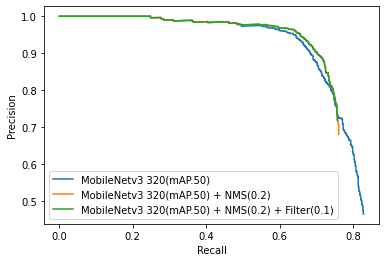

In [ ]:
##############
# Plot the precision-recall curves
#############
def getPrecRec(alltps, allscores, allgtnbr):
    # Sort the bounding boxes, first one has highest confidence score
    orderscoremask = np.array(allscores).argsort()[::-1][:len(allscores)]
    alltps = np.array(alltps)[orderscoremask]

    Acctps = [0]
    Accfps = [0]
    for i in alltps:
      if i == 1:
        Acctps += [Acctps[-1]+1]
        Accfps += [Accfps[-1]]
      if i == 0:
        Acctps += [Acctps[-1]]
        Accfps += [Accfps[-1]+1]

    Acctps = Acctps[1::]
    Accfps = Accfps[1::]

    precision = []
    recall = []
    for i in range(len(Acctps)):
      precision.append(Acctps[i]/(Acctps[i]+Accfps[i]))
      recall.append(Acctps[i]/allgtnbr)

    return precision, recall

#Show performance mAP
# path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_ResNet50_SGD0005_Size575_mAP50.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_MobileNetv3_SGD00005_Size575_mAP50.pkl"
path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_MobileNetv3320_SGD00005_Size575_mAP50.pkl"
prec1 = Performance(root_save=path)
prec1 = prec1.load()

alltps = prec1.epochtps
allscores = prec1.epochscore
allgtnbr = prec1.epochgtnbr
precision, recall = getPrecRec(alltps, allscores, allgtnbr)
# print(recall[-1])
# print(precision[-1])
print("Average Precision", compute_ap(recall, precision))
plt.plot(recall, precision, label = "MobileNetv3 320(mAP.50)")


# path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_ResNet50_SGD0005_Size575_mAP50NMS02.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_MobileNetv3_SGD00005_Size575_mAP50NMS02.pkl"
path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_MobileNetv3320_SGD00005_Size575_mAP50NMS02.pkl"
prec1 = Performance(root_save=path)
prec1 = prec1.load()
alltps = prec1.epochtps
allscores = prec1.epochscore
allgtnbr = prec1.epochgtnbr
print(allgtnbr)
precision, recall = getPrecRec(alltps, allscores, allgtnbr)
print("Average Precision", compute_ap(recall, precision))
plt.plot(recall, precision, label = "MobileNetv3 320(mAP.50) + NMS(0.2)")
# plt.plot([1], [1])

# path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_ResNet50_SGD0005_Size575_mAP50NMS02Filter01.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_MobileNetv3_SGD00005_Size575_mAP50NMS02Filter01.pkl"
path = "/content/drive/MyDrive/Thesis/savedmodel/mAP/scoremAP_fasterrcnnv1_MobileNetv3320_SGD00005_Size575_mAP50NMS02Filter01.pkl"
prec1 = Performance(root_save=path)
prec1 = prec1.load()
alltps = prec1.epochtps
allscores = prec1.epochscore
allgtnbr = prec1.epochgtnbr
precision, recall = getPrecRec(alltps, allscores, allgtnbr)
print("Average Precision", compute_ap(recall, precision))
plt.plot(recall, precision, label = "MobileNetv3 320(mAP.50) + NMS(0.2) + Filter(0.1)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
# plt.savefig("/content/drive/MyDrive/Thesis/performancefigure/precrecmobilenet32050.pdf")
plt.show()

In [ ]:
!pip3 install pickle5
import pickle5 as cPickle
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [ ]:
def create_df(data, name):
  """
  Args:
    data: list of list of scores from many episodes
  """
  iter = 1
  d = {}
  # d = {'col1': [1, 2], 'col2': [3, 4]}
  d[name] = []
  d['Epoch'] = []
  for idx, list_of_val in enumerate(data):
    d[name] += list_of_val
    d["Epoch"] += range(1, len(list_of_val)+1)
  df = pd.DataFrame(data=d)
  # df.index = range(1, len(df)+1)
  df = df.set_index('Epoch')
  return df

30


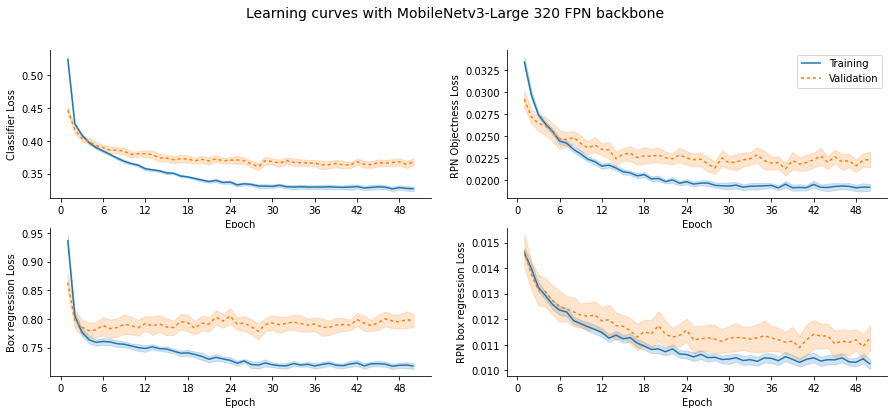

In [ ]:
##########
# Plot the learning curves
###########
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(15, 6))
sns.despine(top=True)
def add_score(trainscore, val_score, changecolor=False):
  score1 = create_df(train_score[0], "Training")
  score2 = create_df(val_score[0], "Validation")
  score = pd.concat([score1, score2], axis=1)
  if changecolor:
    sns.lineplot(data=score, dashes=[(1, 0), (2, 2)], markers=['',''], sizes=(1,1), ax = axs[0,0], palette = ["tab:orange", "tab:orange"]) #'hot'
  else:
    sns.lineplot(data=score, dashes=[(1, 0), (2, 2)], markers=['',''], sizes=(1,1), ax = axs[0,0], palette = ["tab:blue", "tab:orange"])
 
  score1 = create_df(train_score[1], "Training")
  score2 = create_df(val_score[1], "Validation")
  score = pd.concat([score1, score2], axis=1)
  if changecolor:
    sns.lineplot(data=score, dashes=[(1, 0), (2, 2)], markers=['',''], sizes=(1,1), ax = axs[1,0], palette = ["tab:orange", "tab:orange"])
  else:
    sns.lineplot(data=score, dashes=[(1, 0), (2, 2)], markers=['',''], sizes=(1,1), ax = axs[1,0], palette = ["tab:blue", "tab:orange"])

  score1 = create_df(train_score[2], "Training")
  score2 = create_df(val_score[2], "Validation")
  score = pd.concat([score1, score2], axis=1)
  if changecolor:
    sns.lineplot(data=score, dashes=[(1, 0), (2, 2)], markers=['',''], sizes=(1,1), ax = axs[0,1], palette = ["tab:orange", "tab:orange"])
  else:
    sns.lineplot(data=score, dashes=[(1, 0), (2, 2)], markers=['',''], sizes=(1,1), ax = axs[0,1], palette = ["tab:blue", "tab:orange"])

  score1 = create_df(train_score[3], "Training")
  score2 = create_df(val_score[3], "Validation")
  score = pd.concat([score1, score2], axis=1)
  if changecolor:
    sns.lineplot(data=score, dashes=[(1, 0), (2, 2)], markers=['',''], sizes=(1,1), ax = axs[1,1], palette = ["tab:orange", "tab:orange"])
  else:
    sns.lineplot(data=score, dashes=[(1, 0), (2, 2)], markers=['',''], sizes=(1,1), ax = axs[1,1], palette = ["tab:blue", "tab:orange"])

# path = "/content/drive/MyDrive/Thesis/savedmodel/MobileNetOverfitting/score30_MobileNetv3_SGD0005_SchedulerNone_Size224_Batch8_Epoch50_8020.pkl"
path = "/content/drive/MyDrive/Thesis/savedmodel/score1_MobileNetv3_SGD0001_SchedulerNone_Size576_Batch8_Epoch50_8020.pkl"
perf1 = Performance(root_save=path)
perf1 = perf1.load()
train_score = perf1.all_means_training
val_score = perf1.all_means_validation
print(len(val_score[0]))
add_score(train_score, val_score)

# path = "/content/drive/MyDrive/Thesis/savedmodel/MobileNetOverfitting/score30_MobileNetv3320_SGD0005_SchedulerNone_Size576_Batch8_Epoch50_8020.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/score1_MobileNetv3_SGD00005_SchedulerNone_Size224_Batch8_Epoch50_8020_rc.pkl"
# perf1 = Performance(root_save=path)
# perf1 = perf1.load()
# train_score = perf1.all_means_training
# val_score = perf1.all_means_validation
# add_score(train_score, val_score, True)

# path = "/content/drive/MyDrive/Thesis/savedmodel/score30_MobileNetv3_SGD00005_SchedulerNone_Size576_Batch8_Epoch50_8020_rc.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/MobileNetOverfitting/score30_MobileNetv3320_SGD0005_SchedulerNone_Size576_Batch8_Epoch50_8020.pkl"
# perf1 = Performance(root_save=path)
# perf1 = perf1.load()
# train_score = perf1.all_means_training
# val_score = perf1.all_means_validation

axs[0,0].set(ylabel='Classifier Loss')
axs[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,0].set(ylabel='Box regression Loss')
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0,1].set(xlabel='Epoch', ylabel='RPN Objectness Loss ')
axs[0,1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,1].set(xlabel='Epoch', ylabel='RPN box regression Loss')
axs[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[0,0].get_legend().remove()
axs[1,0].get_legend().remove()
axs[1,1].get_legend().remove()
fig.suptitle("Learning curves with MobileNetv3-Large 320 FPN backbone", fontsize=14)

plt.savefig("/content/drive/MyDrive/Thesis/performancefigure/LCmobilenetv3320.pdf")
# plt.legend(bbox_to_anchor=(1.18, 1),borderaxespad=0)
# f.tight_layout()
# plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(15, 6))
sns.despine(top=True)
def add_score(trainscore, val_score, changecolor=False):
  score1 = create_df(train_score[0], "Training")
  score2 = create_df(val_score[0], "Validation")
  score = pd.concat([score1, score2], axis=1)
  if changecolor:
    sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs[0,0], palette = 'hot')
  else:
    sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs[0,0])
 
  score1 = create_df(train_score[1], "Training")
  score2 = create_df(val_score[1], "Validation")
  score = pd.concat([score1, score2], axis=1)
  if changecolor:
    sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs[1,0], palette = 'hot')
  else:
    sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs[1,0])

  score1 = create_df(train_score[2], "Training")
  score2 = create_df(val_score[2], "Validation")
  score = pd.concat([score1, score2], axis=1)
  if changecolor:
    sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs[0,1], palette = 'hot')
  else:
    sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs[0,1])

  score1 = create_df(train_score[3], "Training")
  score2 = create_df(val_score[3], "Validation")
  score = pd.concat([score1, score2], axis=1)
  if changecolor:
    sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs[1,1], palette = 'hot')
  else:
    sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs[1,1])


# path = "/content/drive/MyDrive/Thesis/savedmodel/score30_fasterrcnnv2_SGD0005_SchedulerNone_Size224_Batch8_Epoch50_8020_rc.pkl"
path = "/content/drive/MyDrive/Thesis/savedmodel/bestmodels/score30_fasterrcnnv2_SGD0005_SchedulerReduceLR_Size576_Batch8_Epoch50_8020_rc.pkl"
perf1 = Performance(root_save=path)
perf1 = perf1.load()
train_score = perf1.all_means_training
val_score = perf1.all_means_validation
print(len(val_score[0]))
add_score(train_score, val_score)

# path = "/content/drive/MyDrive/Thesis/savedmodel/bestmodels/score30_fasterrcnnv2_SGD0005_SchedulerReduceLR_Size224_Batch8_Epoch50_8020_rc.pkl"
path = "/content/drive/MyDrive/Thesis/savedmodel/bestmodels/score1_fasterrcnnv2_SGD0005_SchedulerReduceLR_Size576_Batch8_Epoch50_8020_rc.pkl"
perf1 = Performance(root_save=path)
perf1 = perf1.load()
train_score = perf1.all_means_training
val_score = perf1.all_means_validation
add_score(train_score, val_score, True)

# path = "/content/drive/MyDrive/Thesis/savedmodel/score30_MobileNetv3_SGD00005_SchedulerNone_Size576_Batch8_Epoch50_8020_rc.pkl"
# perf1 = Performance(root_save=path)
# perf1 = perf1.load()
# train_score = perf1.all_means_training
# val_score = perf1.all_means_validation

# for i in range(len(train_score)):
#   train_score[i] = [train_score[i][0]]
#   val_score[i] = [val_score[i][0]]
# add_score(train_score, val_score, True)

axs[0,0].set(ylabel='Loss classifier')
axs[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,0].set(ylabel='Loss box reg')
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0,1].set(xlabel='Epoch', ylabel='Loss objectness')
axs[0,1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,1].set(xlabel='Epoch', ylabel='Loss rpn_box_reg')
axs[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.savefig("/content/drive/MyDrive/Thesis/performancefigure/fasterrcnn224rc.pdf")

# plt.legend(bbox_to_anchor=(1.18, 1),borderaxespad=0)
# f.tight_layout()
# plt.show()

0.2614735047168756
0.7356619047925327
1.1316950805434987


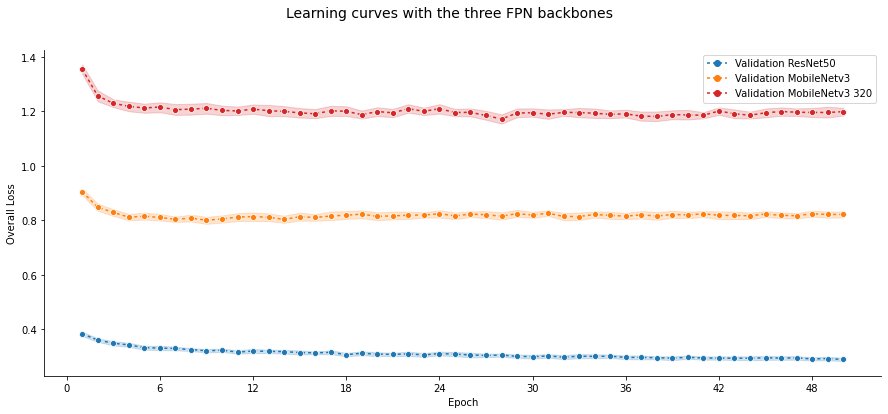

In [ ]:
# Overall loss
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(15, 6))
sns.despine(top=True)
def add_score(train_score, val_score, label, changecolor=False):
  sumtrain_score = [[0]*len(train_score[0][0])]*len(train_score[0])
  for i in range(len(train_score[0])): #runs 30
      sumtrain_score[i] = [sum(x) for x in zip(sumtrain_score[i], train_score[0][i])]
      sumtrain_score[i] = [sum(x) for x in zip(sumtrain_score[i], train_score[1][i])]
      sumtrain_score[i] = [sum(x) for x in zip(sumtrain_score[i], train_score[2][i])]
      sumtrain_score[i] = [sum(x) for x in zip(sumtrain_score[i], train_score[3][i])]
  train_score = sumtrain_score

  sumtrain_score = [[0]*len(val_score[0][0])]*len(val_score[0])
  for i in range(len(val_score[0])): #runs 30
      sumtrain_score[i] = [sum(x) for x in zip(sumtrain_score[i], val_score[0][i])]
      sumtrain_score[i] = [sum(x) for x in zip(sumtrain_score[i], val_score[1][i])]
      sumtrain_score[i] = [sum(x) for x in zip(sumtrain_score[i], val_score[2][i])]
      sumtrain_score[i] = [sum(x) for x in zip(sumtrain_score[i], val_score[3][i])]
  val_score = sumtrain_score
  # print(np.mean(val_score[-1]))
  print(min(min(val_score)))
  score1 = create_df(train_score, "Training")
  # print(score1)
  score2 = create_df(val_score, label)
  # print(score2)

  # score = pd.concat([score1, score2], axis=1)
  score = pd.concat([score2], axis=1)
  
  if changecolor == "blue":
    # sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs, palette = ["tab:blue", "tab:orange"])
    sns.lineplot(data=score, dashes=[(2, 2)], markers=['o'], sizes=(1), ax = axs, palette =  ["tab:blue"])
  elif changecolor == "orange":
    sns.lineplot(data=score, dashes=[(2, 2)], markers=['o'], sizes=(1), ax = axs, palette = ["tab:orange"])
  else:
    # sns.lineplot(data=score, dashes=[(1, 0), (1, 0)], markers=['o','o'], sizes=(1,1), ax = axs, palette = ["tab:blue", "tab:orange"])
    sns.lineplot(data=score, dashes=[(2, 2)], markers=['o'], sizes=(1), ax = axs, palette = ["tab:red"])

# path = "/content/drive/MyDrive/Thesis/savedmodel/score30_fasterrcnnv2_SGD0005_SchedulerNone_Size224_Batch8_Epoch50_8020_rc.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/bestmodels/score30_fasterrcnnv2_SGD0005_SchedulerReduceLR_Size224_Batch8_Epoch50_8020_rc.pkl"
path = "/content/drive/MyDrive/Thesis/savedmodel/v1/score_fasterrcnnv1_SGD0005_SchedulerReduceLR_Size576_Batch8_Epoch50.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/v1/score_fasterrcnnv1_MobileNetv3_SGD00005_SchedulerReduceLR_Size576_Batch8_Epoch50.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/v1/score_fasterrcnnv1_MobileNetv3320_SGD00005_SchedulerReduceLR_Size576_Batch8_Epoch50.pkl"

perf1 = Performance(root_save=path)
perf1 = perf1.load()
train_score = perf1.all_means_training
val_score = perf1.all_means_validation
add_score(train_score, val_score, "Validation ResNet50", "blue")

# path = "/content/drive/MyDrive/Thesis/savedmodel/bestmodels/score30_fasterrcnnv2_SGD0005_SchedulerReduceLR_Size224_Batch8_Epoch50_8020_rc.pkl"
# path = "/content/drive/MyDrive/Thesis/savedmodel/bestmodels/score30_fasterrcnnv2_SGD0005_SchedulerReduceLR_Size576_Batch8_Epoch50_8020_rc.pkl"
path = "/content/drive/MyDrive/Thesis/savedmodel/v1/score_fasterrcnnv1_MobileNetv3_SGD00005_SchedulerReduceLR_Size576_Batch8_Epoch50.pkl"
perf1 = Performance(root_save=path)
perf1 = perf1.load()
train_score = perf1.all_means_training
val_score = perf1.all_means_validation
add_score(train_score, val_score, "Validation MobileNetv3","orange")

path = "/content/drive/MyDrive/Thesis/savedmodel/v1/score_fasterrcnnv1_MobileNetv3320_SGD00005_SchedulerReduceLR_Size576_Batch8_Epoch50.pkl"
perf1 = Performance(root_save=path)
perf1 = perf1.load()
train_score = perf1.all_means_training
val_score = perf1.all_means_validation

# for i in range(len(train_score)):
#   train_score[i] = [train_score[i][0]]
#   val_score[i] = [val_score[i][0]]
add_score(train_score, val_score, "Validation MobileNetv3 320", "red")

axs.set(ylabel='Overall Loss')
axs.xaxis.set_major_locator(MaxNLocator(integer=True))

# print(axs.get_legend())
# axs.get_legend().remove()
fig.suptitle("Learning curves with the three FPN backbones", fontsize=14)
# plt.savefig("/content/drive/MyDrive/Thesis/performancefigure/LCthreebackbones.pdf")